In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import cv2
import torch
import numpy 
import torchvision
from torchvision import transforms                                                                                                                                        
from PIL import Image
from torchsummary import summary
import matplotlib.pyplot as plt

import sys
sys.path.append("../../src/")
sys.path.append("../")
import model
from datasets import imagenet
import config
from aux.utils import obtain_features_map, load_imgs, zscore, extract_valid
from aux.visualization import visualize_features_map
from utils.visualizations.visualize import concat_imgs, preprocess_arrays
from utils.function import recreate_image

# !!Hyperprarameter

In [3]:
selected_layer = 1
selected_filter = 18
num_class = 30
class_index = 950

# Load Images

In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
reverse_mean = [-0.485, -0.456, -0.406]
reverse_std = [1/0.229, 1/0.224, 1/0.225]
train_transform = transforms.Compose([                                                                                                                                
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),                                                                                              
    transforms.ToTensor(),                                                                                                                                            
       ])         
trainset = imagenet.ImageNet(root="/media/lincolnzjx/HardDisk/Datasets/", 
                             is_train=True, transform=train_transform)
trainset.set_data([class_index], num_class)
imgs_path = []                                                                                                                                                            
images = []
labels = []
for img, label, img_path in trainset:                                                                                                                                     
    images.append(img.unsqueeze(0))                                                                                                                                       
    labels.append(label)                                                                                                                                                  
    imgs_path.append(img_path)  

Len of new dataset is :30


# LRP module

## LRP

In [6]:
cd ../

/home/lincolnzjx/Desktop/Interpretation/jupyter


In [7]:
cd ../

/home/lincolnzjx/Desktop/Interpretation


In [8]:
cd extra/

/home/lincolnzjx/Desktop/Interpretation/extra


In [9]:
cd tutorial/

/home/lincolnzjx/Desktop/Interpretation/extra/tutorial


In [10]:
import utilss

In [11]:
def lrp(X, layers, L, selected_filters):
    """LRP
    Args:
        X: (3, 224, 224)
    """
    A = [X]+[None]*L
    for l in range(L): A[l+1] = layers[l].forward(A[l])
        
    scores = numpy.array(A[-1].data.view(-1))
    ind = numpy.argsort(-scores)
    
    _, output_channel, height, width = A[-1].shape
    input_channel, _, _, _ = A[-2].shape
    T = torch.zeros((input_channel, output_channel, height, width))
    T[:,selected_filter, :,:] = 1
    
    R = [None]*L + [(A[-1]*T).data]
    
    for l in range(1,L)[::-1]:
        
        A[l] = (A[l].data).requires_grad_(True)
    
        if isinstance(layers[l],torch.nn.MaxPool2d): 
            layers[l] = torch.nn.AvgPool2d(2)
    
        if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):
            if l <= 16:       
                rho = lambda p: p + 0.25*p.clamp(min=0); 
                incr = lambda z: z+1e-9
            if 17 <= l <= 30: 
                rho = lambda p: p;                       
                incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
            if l >= 31:       
                rho = lambda p: p;                       
                incr = lambda z: z+1e-9
    
            z = incr(utilss.newlayer(layers[l],rho).forward(A[l]))  # step 1
            s = (R[l+1]/z).data                                    # step 2
            (z*s).sum().backward(); c = A[l].grad                  # step 3
            R[l] = (A[l]*c).data                                   # step 4
            
        else:
            R[l] = R[l+1]
    
    # for i,l in enumerate([1]):
    #     utilss.heatmap(numpy.array(R[l][0]).sum(axis=0),0.5*i+1.5,0.5*i+1.5)
    
    A[0] = (A[0].data).requires_grad_(True)
    
    lb = (A[0].data*0+(0-mean)/std).requires_grad_(True)
    hb = (A[0].data*0+(1-mean)/std).requires_grad_(True)
    
    # z = layers[0].forward(A[0]) + 1e-9                                     # step 1 (a)
    # z -= utilss.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
    # z -= utilss.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
    
    
    layers[0].bias = torch.nn.Parameter(torch.zeros_like(layers[0].bias))
    z = layers[0].forward(A[0])                                     # step 1 (a)
    z -= utilss.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
    z -= utilss.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
    z += 1e-9 
    s = (R[1]/z).data                                                      # step 2
    
    (z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad            # step 3
    R[0] = (A[0]*c+lb*cp+hb*cm).data                                       # step 4
    return R

## Main

In [12]:
# Image
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)

# Model
model = torchvision.models.vgg16(pretrained=True) 
model.eval()
layers = list(model._modules['features']) + utilss.toconv(list(model._modules['classifier']))
for index, layer in enumerate(layers):
    print(index, layer)

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 ReLU(inplace=True)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 ReLU(inplace=True)
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 ReLU(inplace=True)
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 ReLU(inplace=True)
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace=True)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 ReLU(inplace=True)
14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 ReLU(inplace=True)
16 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
17 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
18 ReLU(inplace=True)
19 Conv2d(512, 512, kernel_size=(3, 3)

In [4]:
# model
backbone = "vgg16"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = model.Network(backbone=backbone, num_classes=1000)
net.to(device)
# resume from model
resume = "037-0"
model_dir = "/home/lincolnzjx/Desktop/Interpretation/saved/models"
resume_exp = resume.split("-")[0]
resume_epoch = resume.split("-")[1]
print("Resume from model from exp: {} at epoch {}".format(resume_exp, resume_epoch))
resume_path = os.path.join(model_dir, str(resume_exp), str(resume_epoch))
ckpt = torch.load(resume_path, map_location=device)
net.load_state_dict(ckpt, strict=False) 

Entire model.
Resume from model from exp: 037 at epoch 0


<All keys matched successfully>

In [13]:
img = images[0]
img = img[0].permute((1,2,0)).numpy()
X = (torch.FloatTensor(img[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std
R = lrp(X, layers, selected_layer+1, selected_filter)

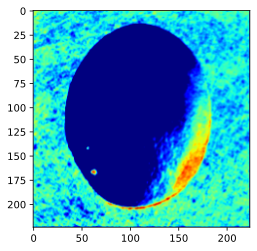

In [14]:
ori = Image.open("/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10061.JPEG").resize((224, 224))
cm = plt.get_cmap("jet")
ori_activation_maps = net.get_activation_maps(X.cuda(), selected_layer)
sel_feature_map = ori_activation_maps[0][0,selected_filter]
min_val = sel_feature_map.min()
max_val = sel_feature_map.max()
sel_feature_map -= sel_feature_map.min()
sel_feature_map /= sel_feature_map.max()
plt.imshow(cm(sel_feature_map))

In [15]:
print(cm(sel_feature_map).max(), sel_feature_map.min())

1.0 0.0


### Standarization

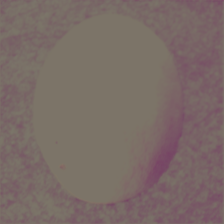

In [16]:
relevance = np.array(R[0][0])
normalized_img = X[0].numpy()
relevance_img = relevance * normalized_img
new_image = recreate_image(relevance_img, reverse_mean, reverse_std)
Image.fromarray(new_image)

In [17]:
print(relevance.max(), relevance.min())

0.6322923 0.0


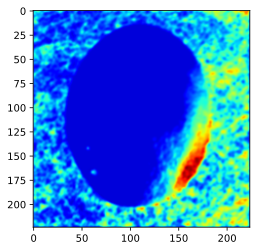

In [18]:
opt_activation_maps = net.get_activation_maps(torch.FloatTensor(relevance_img).unsqueeze(dim=0).cuda(), selected_layer)
opt_sel_feature_map = opt_activation_maps[0][0,selected_filter]
opt_sel_feature_map -= min_val
opt_sel_feature_map = np.maximum(0, opt_sel_feature_map)
opt_sel_feature_map /= opt_sel_feature_map.max()
opt_sel_feature_map = np.minimum(1, opt_sel_feature_map)
plt.imshow(cm(opt_sel_feature_map))

### Remove negative

0.6322923 0.0


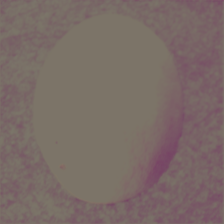

In [19]:
relevance = np.maximum(np.array(R[0][0]), 0)
normalized_img = X[0].numpy()
relevance_img = relevance * normalized_img
new_image = recreate_image(relevance_img, reverse_mean, reverse_std)
print(relevance.max(), relevance.min())
Image.fromarray(new_image)

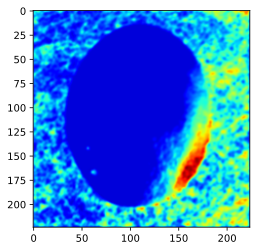

In [20]:
opt_activation_maps = net.get_activation_maps(torch.FloatTensor(relevance_img).unsqueeze(dim=0).cuda(), selected_layer)
opt_sel_feature_map = opt_activation_maps[0][0,selected_filter]
opt_sel_feature_map -= min_val
opt_sel_feature_map = np.maximum(0, opt_sel_feature_map)
opt_sel_feature_map /= opt_sel_feature_map.max()
opt_sel_feature_map = np.minimum(1, opt_sel_feature_map)
plt.imshow(cm(opt_sel_feature_map))

### Scale

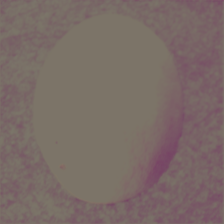

In [21]:
relevance = np.maximum(np.array(R[0][0]), 0)
relevance -= relevance.min()
relevance /= relevance.max()
normalized_img = X[0].numpy()
new_image = recreate_image(relevance_img, reverse_mean, reverse_std)
Image.fromarray(new_image)

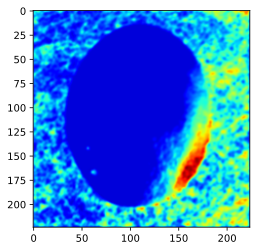

In [22]:
opt_activation_maps = net.get_activation_maps(torch.FloatTensor(relevance_img).unsqueeze(dim=0).cuda(), selected_layer)
opt_sel_feature_map = opt_activation_maps[0][0,selected_filter]
opt_sel_feature_map -= min_val
opt_sel_feature_map = np.maximum(0, opt_sel_feature_map)
opt_sel_feature_map /= opt_sel_feature_map.max()
opt_sel_feature_map = np.minimum(1, opt_sel_feature_map)
plt.imshow(cm(opt_sel_feature_map))

### Totla Scale

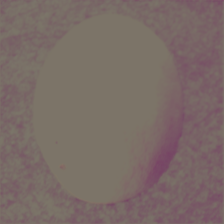

In [23]:
relevance = np.array(R[0][0])
relevance -= relevance.min()
relevance /= relevance.max()
normalized_img = X[0].numpy()
new_image = recreate_image(relevance_img, reverse_mean, reverse_std)
Image.fromarray(new_image)

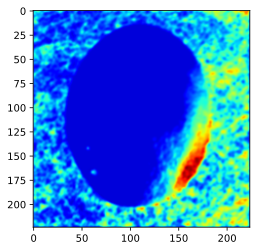

In [24]:
opt_activation_maps = net.get_activation_maps(torch.FloatTensor(relevance_img).unsqueeze(dim=0).cuda(), selected_layer)
opt_sel_feature_map = opt_activation_maps[0][0,selected_filter]
opt_sel_feature_map -= min_val
opt_sel_feature_map = np.maximum(0, opt_sel_feature_map)
opt_sel_feature_map /= opt_sel_feature_map.max()
opt_sel_feature_map = np.minimum(1, opt_sel_feature_map)
plt.imshow(cm(opt_sel_feature_map))

In [123]:
opt = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/pack/7013/149999/n07747607_10061.png")

In [124]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
opt_arr = np.expand_dims(np.array(opt)/255, axis=0)
opt_nor = zscore(opt_arr, mean, std)

(1, 224, 224, 3)


In [130]:
opt_nor.shape

(1, 3, 224, 224)

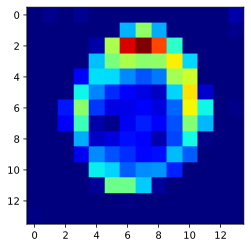

In [136]:
opt_activation_maps = net.get_activation_maps(torch.FloatTensor(opt_nor).cuda(), selected_layer)
opt_sel_feature_map = opt_activation_maps[0][0,selected_filter]
opt_sel_feature_map -= min_val
opt_sel_feature_map = np.maximum(0, opt_sel_feature_map)
opt_sel_feature_map /= opt_sel_feature_map.max()
opt_sel_feature_map = np.minimum(1, opt_sel_feature_map)
plt.imshow(cm(opt_sel_feature_map))

In [134]:
opt_arr.shape

(1, 224, 224, 3)

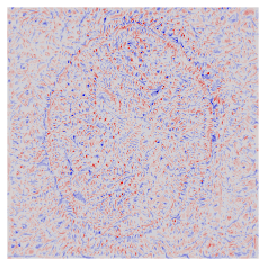

In [138]:
#utilss.heatmap(numpy.array(R[0][0]).sum(axis=0),3.5,3.5)
utilss.heatmap(opt_nor[0].sum(axis=0),3.5,3.5)

In [140]:
opt_arr[0].shape

(224, 224, 3)

In [ ]:
import cv2

img = cv2.imread("/home/lincolnzjx/Desktop/Interpretation/saved/pack/7013/149999/n07747607_10061.png", 1)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imshow("src", gray)

dst = cv2.equalizeHist(gray)
cv2.imshow("dst", dst)
cv2.waitKey(0)

### Original Images

0.3702747 0.0


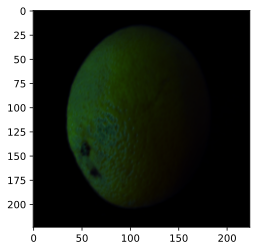

In [77]:
relevance = np.array(R[0][0])
relevance -= relevance.min()
relevance /= relevance.max()
normalized_img = images[0][0].numpy()
relevance_img = normalized_img * relevance
relevance_img = relevance_img.transpose(1,2,0)
print(relevance_img.max(), relevance_img.min())
plt.imshow(relevance_img)
# new_image = recreate_image(relevance_img, reverse_mean, reverse_std)
# Image.fromarray(new_image)

0.3702747 0.0


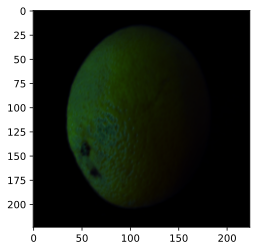

In [76]:
relevance = np.maximum(np.array(R[0][0]), 0)
relevance -= relevance.min()
relevance /= relevance.max()
normalized_img = images[0][0].numpy()
relevance_img = normalized_img * relevance
print(relevance_img.max(), relevance_img.min())
relevance_img = relevance_img.transpose(1,2,0)
plt.imshow(relevance_img)
# new_image = recreate_image(relevance_img, reverse_mean, reverse_std)
# Image.fromarray(new_image)

In [72]:
np.array(new_image).min()

104

In [104]:
utilss.heatmap(numpy.array(R[0][0]).sum(axis=0),3.5,3.5)

castle.jpg  data/  params/  __pycache__/  utilss.py


In [27]:
for img in images:
    print(img)
    img = img[0].permute((1,2,0)).numpy()
    X = (torch.FloatTensor(img[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std
    R = lrp(X, layers, selected_layer, selected_filter)
    #utilss.heatmap(numpy.array(R[0][0]).sum(axis=0),3.5,3.5)

tensor([[[[0.2667, 0.2863, 0.2667,  ..., 0.1137, 0.1059, 0.1137],
          [0.2667, 0.2824, 0.2824,  ..., 0.1098, 0.1137, 0.1294],
          [0.2196, 0.2314, 0.2706,  ..., 0.1098, 0.1216, 0.1294],
          ...,
          [0.2667, 0.2667, 0.2314,  ..., 0.1569, 0.1647, 0.1647],
          [0.2706, 0.2863, 0.2510,  ..., 0.1569, 0.1765, 0.1647],
          [0.2235, 0.2431, 0.2275,  ..., 0.1647, 0.1882, 0.1843]],

         [[0.2745, 0.3098, 0.2863,  ..., 0.1216, 0.1098, 0.1137],
          [0.2824, 0.2941, 0.2824,  ..., 0.1098, 0.1137, 0.1294],
          [0.2431, 0.2510, 0.3020,  ..., 0.1098, 0.1216, 0.1294],
          ...,
          [0.2784, 0.2902, 0.2627,  ..., 0.1608, 0.1765, 0.1804],
          [0.2706, 0.2941, 0.2706,  ..., 0.1647, 0.1961, 0.1922],
          [0.2118, 0.2471, 0.2314,  ..., 0.1843, 0.2157, 0.2078]],

         [[0.3176, 0.3412, 0.3020,  ..., 0.1098, 0.0980, 0.1020],
          [0.3098, 0.3294, 0.3255,  ..., 0.1020, 0.1059, 0.1137],
          [0.2549, 0.2706, 0.3373,  ..., 0

tensor([[[[0.0510, 0.0431, 0.0431,  ..., 0.0039, 0.0039, 0.0000],
          [0.0314, 0.0353, 0.0549,  ..., 0.0039, 0.0078, 0.0039],
          [0.0392, 0.0588, 0.0667,  ..., 0.0078, 0.0039, 0.0039],
          ...,
          [0.0157, 0.0196, 0.0157,  ..., 0.0078, 0.0039, 0.0039],
          [0.0196, 0.0157, 0.0118,  ..., 0.0118, 0.0078, 0.0078],
          [0.0078, 0.0157, 0.0118,  ..., 0.0078, 0.0039, 0.0039]],

         [[0.0549, 0.0627, 0.0745,  ..., 0.0078, 0.0039, 0.0000],
          [0.0667, 0.0745, 0.0824,  ..., 0.0039, 0.0039, 0.0039],
          [0.0627, 0.0902, 0.1294,  ..., 0.0039, 0.0039, 0.0039],
          ...,
          [0.0157, 0.0196, 0.0235,  ..., 0.0078, 0.0039, 0.0039],
          [0.0118, 0.0157, 0.0196,  ..., 0.0078, 0.0078, 0.0039],
          [0.0157, 0.0078, 0.0157,  ..., 0.0078, 0.0039, 0.0039]],

         [[0.0941, 0.0941, 0.1059,  ..., 0.0039, 0.0039, 0.0000],
          [0.1020, 0.1294, 0.1373,  ..., 0.0000, 0.0039, 0.0039],
          [0.2235, 0.2941, 0.3490,  ..., 0

tensor([[[[0.7098, 0.7098, 0.7216,  ..., 0.5804, 0.5725, 0.5765],
          [0.7176, 0.7059, 0.7176,  ..., 0.5804, 0.5843, 0.5843],
          [0.7216, 0.7098, 0.7216,  ..., 0.5804, 0.5843, 0.5843],
          ...,
          [0.7961, 0.7961, 0.7922,  ..., 0.5843, 0.5765, 0.5804],
          [0.7922, 0.7922, 0.7882,  ..., 0.6000, 0.6039, 0.6039],
          [0.8000, 0.7961, 0.7843,  ..., 0.6118, 0.6196, 0.6196]],

         [[0.3647, 0.3647, 0.4000,  ..., 0.6000, 0.5961, 0.6000],
          [0.3686, 0.3647, 0.4039,  ..., 0.5961, 0.5961, 0.6000],
          [0.3608, 0.3569, 0.3961,  ..., 0.5922, 0.5961, 0.5961],
          ...,
          [0.5059, 0.5176, 0.5020,  ..., 0.5412, 0.5333, 0.5373],
          [0.5137, 0.5059, 0.4745,  ..., 0.5569, 0.5647, 0.5647],
          [0.5176, 0.5137, 0.4784,  ..., 0.5765, 0.5804, 0.5843]],

         [[0.0980, 0.1137, 0.1373,  ..., 0.6431, 0.6353, 0.6392],
          [0.1098, 0.1137, 0.1451,  ..., 0.6314, 0.6314, 0.6353],
          [0.1020, 0.1216, 0.1529,  ..., 0

tensor([[[[0.2392, 0.2235, 0.2235,  ..., 0.1255, 0.1137, 0.1176],
          [0.2431, 0.2275, 0.2196,  ..., 0.1176, 0.1098, 0.1020],
          [0.2588, 0.2353, 0.2235,  ..., 0.1255, 0.1216, 0.0980],
          ...,
          [0.8627, 0.8706, 0.8745,  ..., 0.0784, 0.0706, 0.0627],
          [0.8314, 0.8471, 0.8510,  ..., 0.0745, 0.0706, 0.0627],
          [0.8000, 0.8157, 0.8314,  ..., 0.0706, 0.0627, 0.0588]],

         [[0.1608, 0.1569, 0.1529,  ..., 0.0941, 0.0824, 0.0824],
          [0.1647, 0.1608, 0.1569,  ..., 0.0980, 0.0863, 0.0824],
          [0.1804, 0.1765, 0.1608,  ..., 0.0941, 0.0902, 0.0745],
          ...,
          [0.8588, 0.8667, 0.8706,  ..., 0.0824, 0.0745, 0.0667],
          [0.8314, 0.8431, 0.8510,  ..., 0.0784, 0.0706, 0.0667],
          [0.8000, 0.8157, 0.8314,  ..., 0.0706, 0.0627, 0.0627]],

         [[0.1333, 0.1255, 0.1216,  ..., 0.0784, 0.0706, 0.0706],
          [0.1373, 0.1294, 0.1255,  ..., 0.0745, 0.0667, 0.0667],
          [0.1529, 0.1451, 0.1294,  ..., 0

tensor([[[[0.0000, 0.0039, 0.0039,  ..., 0.0118, 0.0078, 0.0118],
          [0.0039, 0.0039, 0.0039,  ..., 0.0078, 0.0078, 0.0078],
          [0.0039, 0.0039, 0.0000,  ..., 0.0118, 0.0078, 0.0118],
          ...,
          [0.0353, 0.0196, 0.0118,  ..., 0.0078, 0.0157, 0.0275],
          [0.0196, 0.0235, 0.0235,  ..., 0.0157, 0.0235, 0.0118],
          [0.0118, 0.0196, 0.0275,  ..., 0.0118, 0.0118, 0.0235]],

         [[0.0000, 0.0039, 0.0039,  ..., 0.0118, 0.0157, 0.0157],
          [0.0039, 0.0039, 0.0039,  ..., 0.0078, 0.0157, 0.0157],
          [0.0039, 0.0039, 0.0000,  ..., 0.0118, 0.0078, 0.0118],
          ...,
          [0.0863, 0.0431, 0.0314,  ..., 0.0275, 0.0431, 0.0549],
          [0.0588, 0.0471, 0.0510,  ..., 0.0314, 0.0471, 0.0392],
          [0.0353, 0.0549, 0.0627,  ..., 0.0314, 0.0392, 0.0510]],

         [[0.0000, 0.0039, 0.0039,  ..., 0.0078, 0.0157, 0.0196],
          [0.0039, 0.0039, 0.0039,  ..., 0.0157, 0.0078, 0.0039],
          [0.0039, 0.0039, 0.0000,  ..., 0

In [25]:
pwd

'/home/lincolnzjx/Desktop/Interpretation/extra/tutorial'

# Analysis

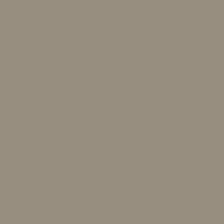

In [163]:
new_img = recreate_image(R[0][0], reverse_mean, reverse_std)
Image.fromarray(new_img)

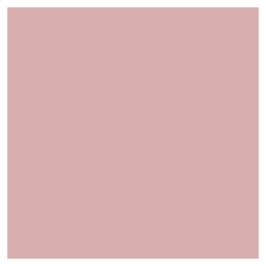

In [128]:
utilss.heatmap(new_img.transpose(2,0,1).sum(axis=0),3.5,3.5)

#### L1F47, not inverse standard optimized result using  visualization method of  LRP

(3, 224, 224)


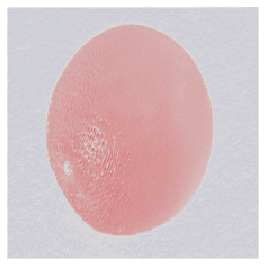

In [161]:
arr = np.load("/home/lincolnzjx/Desktop/Interpretation/saved/pack/7001/52734/52734.npy")
print(arr[0].shape)
utilss.heatmap(arr[0].sum(axis=0), 3.5, 3.5)

#### L1F16, not inverse standard optimized result using  visualization method of  LRP

(3, 224, 224)


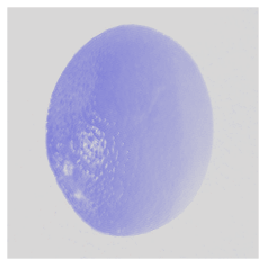

In [162]:
arr = np.load("/home/lincolnzjx/Desktop/Interpretation/saved/pack/7000/46785/46785.npy")
print(arr[0].shape)
utilss.heatmap(arr[0].sum(axis=0), 3.5, 3.5)

#### L1F47, optimized result using  visualization method of  LRP

(3, 224, 224)


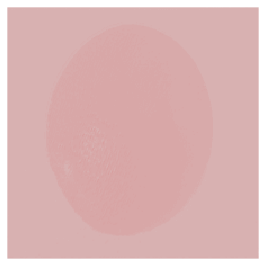

In [158]:
opt_img = Image.open('/home/lincolnzjx/Desktop/Interpretation/saved/pack/7001/52734/n07747607_10061.png')
opt_img = np.transpose(opt_img, (2,0,1))
print(opt_img.shape)
utilss.heatmap(np.sum(opt_img, axis=0), 3.5, 3.5)

#### L1F16, optimized result using  visualization method of  LRP

(3, 224, 224)


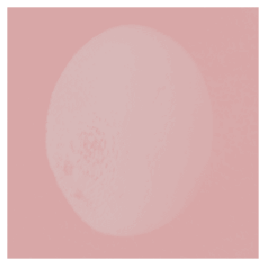

In [159]:
opt_img = Image.open('/home/lincolnzjx/Desktop/Interpretation/saved/pack/7000/46785/n07747607_10061.png')
opt_img = np.transpose(opt_img, (2,0,1))
print(opt_img.shape)
utilss.heatmap(np.sum(opt_img, axis=0), 3.5, 3.5)

#### L25F1, not inverse standard optimized result using  visualization method of  LRP

(3, 224, 224)


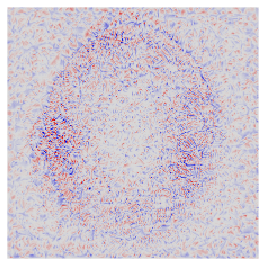

In [15]:
arr = np.load("/home/lincolnzjx/Desktop/Interpretation/saved/pack/7012/79405/79405.npy")
print(arr[0].shape)
utilss.heatmap(arr[0].sum(axis=0), 3.5, 3.5)

#### L18F49, not inverse standard optimized result using  visualization method of  LRP

(3, 224, 224)


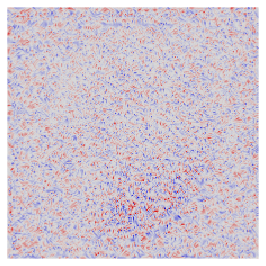

In [16]:
arr = np.load("/home/lincolnzjx/Desktop/Interpretation/saved/pack/7010/149999/149999.npy")
print(arr[0].shape)
utilss.heatmap(arr[0].sum(axis=0), 3.5, 3.5)

#### L15F173, not inverse standard optimized result using  visualization method of  LRP

(3, 224, 224)


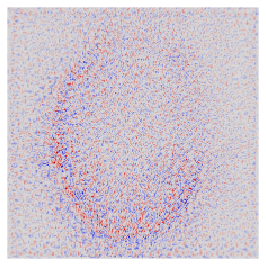

In [17]:
arr = np.load("/home/lincolnzjx/Desktop/Interpretation/saved/pack/7009/149999/149999.npy")
print(arr[0].shape)
utilss.heatmap(arr[0].sum(axis=0), 3.5, 3.5)

In [43]:
image = Image.open("../../saved/generated/LRP/052490/n07747607_10061.png")
ori_image = Image.open("/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10061.JPEG").resize((224, 224))

In [44]:
image = np.array(image)
#image = (image - image.min()) / image.max()

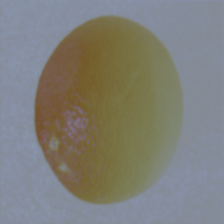

In [45]:
Image.fromarray((image * 255).astype(np.uint8))

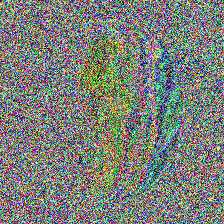

In [46]:
Image.fromarray((image*np.array(ori_image) * 255).astype(np.uint8))

In [59]:
summary(torchvision.models.vgg16().cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [42]:
vgg16 = torchvision.models.vgg16()

In [43]:
for index, layer in enumerate(vgg16.features.children()):
    if isinstance(layer, torch.nn.Conv2d):
        print(index, layer)
#         print(layer.out_channels)
        print(torch.sum(layer.weight)/layer.out_channels)
        print(layer.bias)
#         print(torch.sum(layer.bias))
        print("-"*50)

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
tensor(-0.0648, grad_fn=<DivBackward0>)
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)
--------------------------------------------------
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
tensor(-0.1313, grad_fn=<DivBackward0>)
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)
--------------------------------------------------
5 Conv2d(64, 128, kerne